In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import OrderedDict
from typing import List, Tuple
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import medmnist
from medmnist.dataset import PneumoniaMNIST  # Dataset
from medmnist.dataset import OrganAMNIST, OrganCMNIST, OrganSMNIST
from medmnist import INFO, Evaluator

import flwr as fl
from flwr.common import Metrics

In [20]:
torch.cuda.is_available()

True

In [21]:
DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.0.0+cu117 and Flower 1.3.0


In [22]:
num_epochs = 50
BATCH_SIZE = 512
lr = 0.005

### Getting the Dataset 

In [23]:
# data_flag = 'pneumoniamnist'
# data_flag = 'organamnist'
data_flag = 'organcmnist'
# data_flag = 'organsmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [24]:
# Do some preprocessing on the data
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Split the Data
train_dataset = DataClass(
    split='train', transform=data_transform, download=download)
valid_dataset = DataClass(
    split='val',   transform=data_transform, download=download)
test_dataset = DataClass(
    split='test',  transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# Convert to DataLoader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,   shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=2*BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(
    dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\aaron\.medmnist\organcmnist.npz
Using downloaded and verified file: C:\Users\aaron\.medmnist\organcmnist.npz
Using downloaded and verified file: C:\Users\aaron\.medmnist\organcmnist.npz
Using downloaded and verified file: C:\Users\aaron\.medmnist\organcmnist.npz


In [25]:
print(train_dataset)
print("#########################################################################################################")
print(valid_dataset)
print("#########################################################################################################")
print(test_dataset)

Dataset OrganCMNIST (organcmnist)
    Number of datapoints: 13000
    Root location: C:\Users\aaron\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 13000, 'val': 2392, 'test': 8268}
    Description: The OrganCMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Coronal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in coronal views (planes). The images are resized into 1×28×28 to perform multi-cl

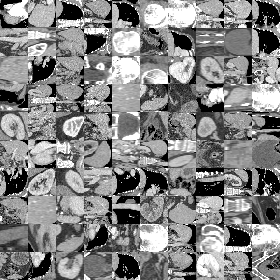

In [26]:
train_dataset.montage(length=10)

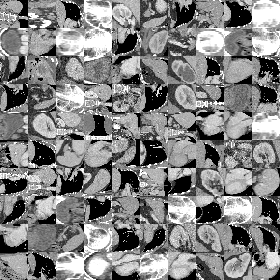

In [27]:
valid_dataset.montage(length=10)

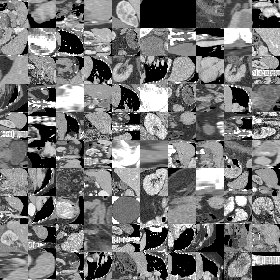

In [28]:
test_dataset.montage(length=10)

### Encoder

In [29]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()  # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

### Decoder

In [12]:
class Decoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

### Autoencoder

In [30]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [31]:
# Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [32]:
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Cuda
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() = vae.encoder.kl
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)

In [33]:
# Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():  # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() = vae.encoder.kl
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [34]:
for epoch in range(num_epochs):
    train_loss = train_epoch(vae, device, train_loader, optim)
    val_loss = test_epoch(vae, device, valid_loader)
    print(
        f'\n EPOCH {epoch+1}/{num_epochs} \t train loss {train_loss:.3f} \t val loss {val_loss:.3f}')

	 partial train loss (single batch): 283253.875000
	 partial train loss (single batch): 287614.312500
	 partial train loss (single batch): 270469.750000
	 partial train loss (single batch): 257973.671875
	 partial train loss (single batch): 262334.531250
	 partial train loss (single batch): 264567.125000
	 partial train loss (single batch): 257369.015625
	 partial train loss (single batch): 242578.171875
	 partial train loss (single batch): 243079.515625
	 partial train loss (single batch): 244806.437500
	 partial train loss (single batch): 237766.500000
	 partial train loss (single batch): 238806.421875
	 partial train loss (single batch): 225100.500000
	 partial train loss (single batch): 222902.218750
	 partial train loss (single batch): 212350.484375
	 partial train loss (single batch): 225484.453125
	 partial train loss (single batch): 213822.125000
	 partial train loss (single batch): 205887.234375
	 partial train loss (single batch): 202846.828125
	 partial train loss (single ba

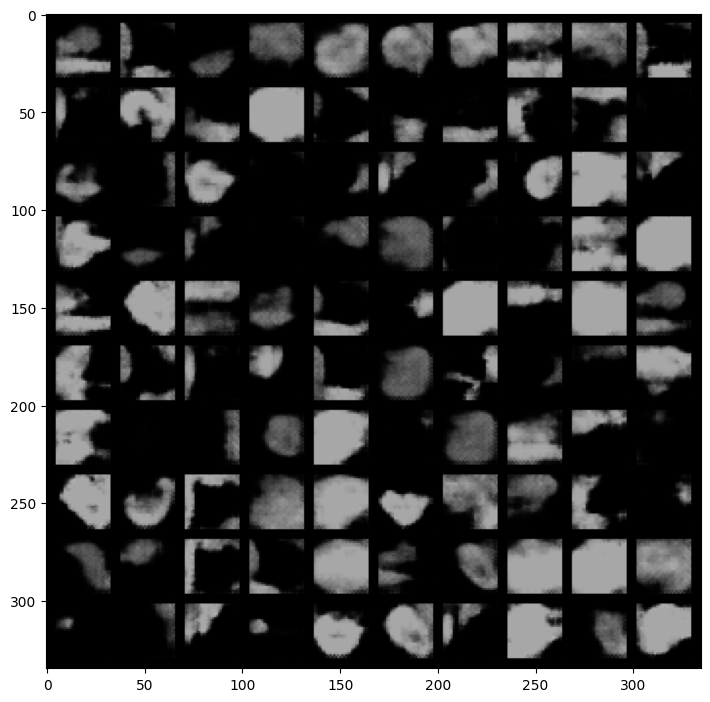

In [35]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():
    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100], 10, 5))
    plt.show()

In [36]:
import plotly.express as px
from sklearn.manifold import TSNE
from tqdm import tqdm

# Taken from example on Auto Encoders with regular MNist Data

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i,
                      enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 8268/8268 [00:12<00:00, 637.33it/s]


In [37]:
# Taken from SK Learn example on viewing multidimensional data

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'], axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(
    str), labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

### Updating Model Parameters

In [38]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### Flower Client

In [54]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [40]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /+ len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [41]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)
    
    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}
    
    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [50]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = DataClass(split='train', transform=transform, download=download)
    testset = DataClass(split='test',  transform=transform, download=download)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and reate DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

Using downloaded and verified file: C:\Users\aaron\.medmnist\organcmnist.npz
Using downloaded and verified file: C:\Users\aaron\.medmnist\organcmnist.npz


### Virtual CLient Engine

In [47]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

### Start Training

In [55]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-17 21:20:31,005 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-17 21:20:36,116	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-17 21:20:38,430 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3359154585.0, 'memory': 6718309172.0, 'CPU': 16.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0}
INFO flwr 2023-04-17 21:20:38,432 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-17 21:20:38,432 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-17 21:20:41,941 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-17 21:20:41,941 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-17 21:20:41,942 | server.py:101 | FL starting
DEBUG flwr 2023-04-17 21:20:41,942 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flw

(scheduler +24m11s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-17 21:20:52,550 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=32972, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
  File "c:\Users\aaron\anaconda3\envs\cudaflower\lib\site-packages\flwr\simulation\ray_transport\ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "c:\Users\aaron\anaconda3\envs\cudaflower\lib\site-packages\flwr\client\client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "c:\Users\aaron\anaconda3\envs\cudaflower\lib\site-packages\flwr\client\app.py", line 258, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "C:\Users\aaron\AppData\Local\Temp\ipykernel_10024\812269180.py", line 12, in fit
  File "C:\Users\aaron\AppData\Local\Temp\ipykernel_10024\1440847558.py", line 8, in train
  File "c:\Users\aaron\anaconda3\envs\cudaflower\lib\site-pack

KeyboardInterrupt: 